In [47]:
import logging
from binance.um_futures import UMFutures as Client
from binance.lib.utils import config_logging
from binance.error import ClientError
import dateparser
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
from scipy import signal
from datetime import datetime

In [48]:
akey = os.environ.get("API_KEY")
asec = os.environ.get("API_SECRET")


#config_logging(logging, logging.DEBUG)
futures_client = Client(key = akey, secret= asec)

In [49]:
#PARAMETERS
TIMEFRAME = "15m"
PAIR = "ETHUSDT"
BLOCK = 512
DATA_WINDOW_LENGTH = BLOCK
ROLLING_WINDOW_LENGTH = 12 #this is correlated with the chosen TIMEFRAME and as such should be a function of that; something about the frequency of local minima and maxima
CALLBACKRATE_FACTOR = 10
FROM_DATE = "2018-10-14 01:00:00" 
TO_DATE = "2022-10-05 01:00:00"
NUM_DATA = 10000 #max 100k
DATA_DIR = "data"
DUMP = 'csv'

path = os.path.join(DATA_DIR, PAIR); print(path)
if not os.path.exists(path):
    os.makedirs(path)

tk1 = os.path.join(PAIR, f'{FROM_DATE.replace(" ", "_").replace(":", "")}_{TIMEFRAME}_{TO_DATE.replace(" ", "_").replace(":", "")}')

path = os.path.join(DATA_DIR, tk1)
if not os.path.exists(path):
    os.makedirs(path)


data\ETHUSDT


In [68]:
class StaticDatabase:
    def __init__(self, client, pair, timeframe, from_date, to_date, contractType = 'PERPETUAL', limit=1500):
        self.client = client
        self.pair = pair
        self.timeframe = timeframe
        self.contractType = contractType
        self.limit = limit
        self.from_date = dateparser.parse(from_date)
        self.to_date = dateparser.parse(to_date)
        self.from_ts = round(datetime.timestamp(self.from_date)*1000)
        self.to_ts = round(datetime.timestamp(self.to_date)*1000)
        self.data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.from_ts, limit = self.limit))    
        self.length = len(self.data)
        # self.data = pd.DataFrame()
    
    def get_historical_klines(self):

        # self.data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.from_ts, limit = self.limit))    
        self.last_ts = round(datetime.timestamp(pd.to_datetime(self.data.iloc[-1]['open_time'], unit='ms'))*1000)
        self.new_data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.last_ts, limit = self.limit))
        self.data = pd.concat([self.data, self.new_data], axis=0).reset_index(drop=True)
        self.length = len(self.data)
        # print(self.data.iloc[-1]['open_time'])
        # pd.to_datetime(self.data.iloc[-1]['open_time'], unit='ms')
        # self.last_ts = round(datetime.timestamp(dateparser.parse(str(self.data.iloc[-1]['open_time'])))*1000)
        # self.last_ts = round(datetime.timestamp(pd.to_datetime(self.data.iloc[-1]['open_time'], unit='ms'))*1000)
        print(self.to_ts, self.last_ts)
        print(type(self.to_ts), type(self.last_ts))
        print(self.last_ts < self.to_ts)
        
        while (self.length < NUM_DATA) and (self.last_ts < self.to_ts):
                # print(1)
                print(self.data.shape)
                self.last_ts = round(datetime.timestamp(pd.to_datetime(self.data.iloc[-1]['open_time'], unit='ms'))*1000)
                self.new_data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.last_ts, limit=self.limit))    
                self.data = pd.concat([self.data, self.new_data], axis=0).reset_index(drop=True)
                self.length = len(self.data)
                
    def process_klines(self, klines):
        df = pd.DataFrame(klines)
        df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'ignore']
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
        df['open'] = pd.to_numeric(df['open'])
        df['high'] = pd.to_numeric(df['high'])
        df['low'] = pd.to_numeric(df['low'])
        df['close'] = pd.to_numeric(df['close'])
        df['volume'] = pd.to_numeric(df['volume'])
        df['quote_asset_volume'] = pd.to_numeric(df['quote_asset_volume'])
        df['trades'] = pd.to_numeric(df['trades'])
        df['taker_buy_volume'] = pd.to_numeric(df['taker_buy_volume'])
        df['taker_buy_quote_asset_volume'] = pd.to_numeric(df['taker_buy_quote_asset_volume'])
        df['ignore'] = pd.to_numeric(df['ignore'])
        df.drop(['ignore'], axis=1, inplace=True)
        return df    



In [69]:
sdb = StaticDatabase(futures_client, PAIR, TIMEFRAME, FROM_DATE, TO_DATE)

C:\Users\igor-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


In [70]:
sdb.get_historical_klines()

1664956800000 1576218600000
<class 'int'> <class 'int'>
True
(3000, 11)
(4500, 11)
(6000, 11)
(7500, 11)
(9000, 11)


<AxesSubplot: >

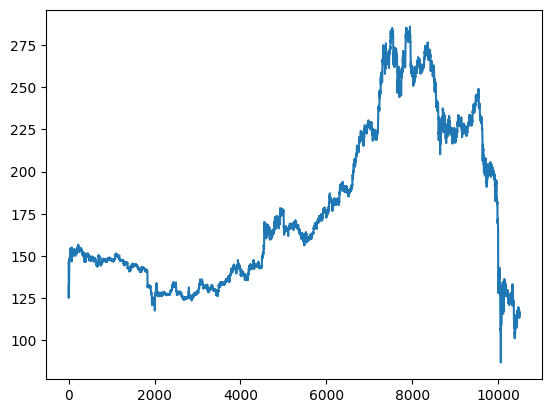

In [71]:
sdb.data.close.plot()

In [73]:
len(sdb.data)

10500

In [74]:
df = sdb.data

In [75]:
if DUMP == 'json':
    sdb.data.to_json(os.path.join(DATA_DIR, tk1, f"{PAIR}_{TIMEFRAME}.json"))
elif DUMP == 'csv':
    sdb.data.to_csv(os.path.join(DATA_DIR, tk1, f"{PAIR}_{TIMEFRAME}.csv"))    


In [76]:
closes_mean = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
closes_std = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).std()
mean_std = closes_std.mean()
closes_mean.mean(), mean_std

(176.79412250833718, 0.6553085468383807)

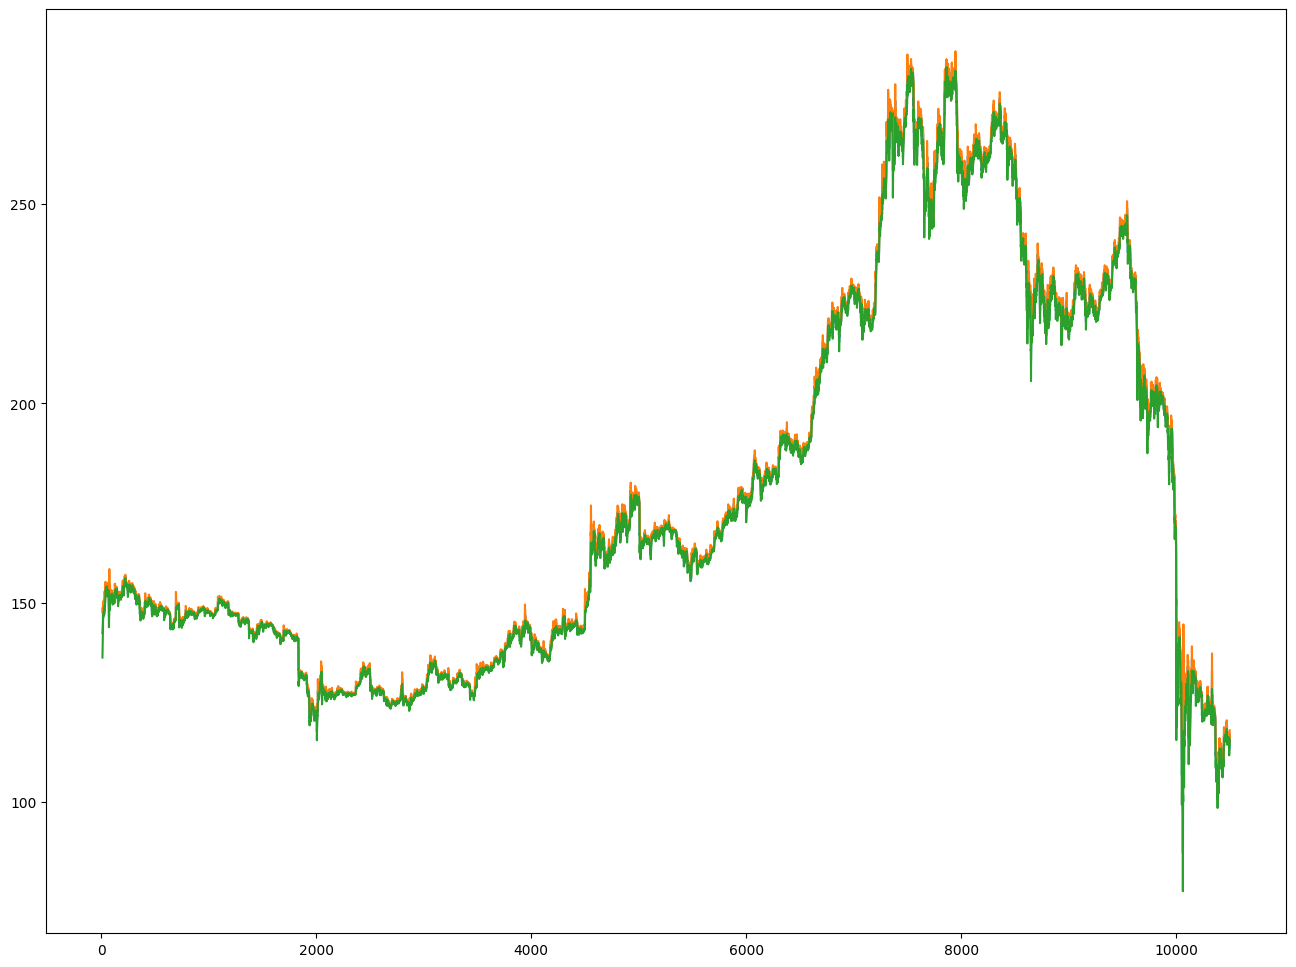

In [77]:
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(closes_mean)
ax.plot(closes_mean + closes_std)
ax.plot(closes_mean - closes_std)

In [78]:

# peak_indexes, _ = signal.find_peaks(df.close.values, threshold=mean_std/2)
# peak_indexes, _ = signal.find_peaks(df.close.values, prominence=1.5*mean_std)
peak_indexes, _ = signal.find_peaks(df.close.values, prominence=2*mean_std)
print(peak_indexes)

# valley_indexes, _ = signal.find_peaks(-1*df.close.values, threshold=mean_std/2)
# valley_indexes, _ = signal.find_peaks(-1*df.close.values, prominence=1.5*mean_std)
valley_indexes, _ = signal.find_peaks((-1)*df.close.values, prominence=2*mean_std)
print(valley_indexes)

[    3    31    50    68    75    77   100   128   201   224   259   288
   351   373   409   445   490   504   547   604   694   786   819   950
  1099  1322  1465  1492  1540  1701  1817  1858  1866  1906  1947  1963
  1997  2015  2021  2045  2050  2065  2091  2124  2146  2205  2418  2438
  2498  2587  2799  2831  2883  2994  3060  3067  3104  3166  3194  3229
  3334  3514  3529  3552  3675  3721  3791  3801  3844  3926  3942  3993
  4013  4032  4065  4115  4194  4204  4226  4232  4296  4313  4347  4418
  4462  4521  4542  4556  4559  4562  4573  4583  4606  4623  4635  4651
  4664  4671  4702  4724  4737  4759  4768  4785  4797  4804  4809  4848
  4862  4871  4883  4910  4926  4932  4939  4959  4968  4977  5001  5029
  5058  5088  5150  5173  5211  5253  5281  5319  5380  5410  5447  5502
  5522  5575  5629  5733  5786  5812  5815  5844  5873  5885  5913  5928
  5959  5967  5991  6021  6043  6054  6080  6085  6112  6122  6141  6149
  6175  6191  6211  6250  6306  6319  6325  6340  6

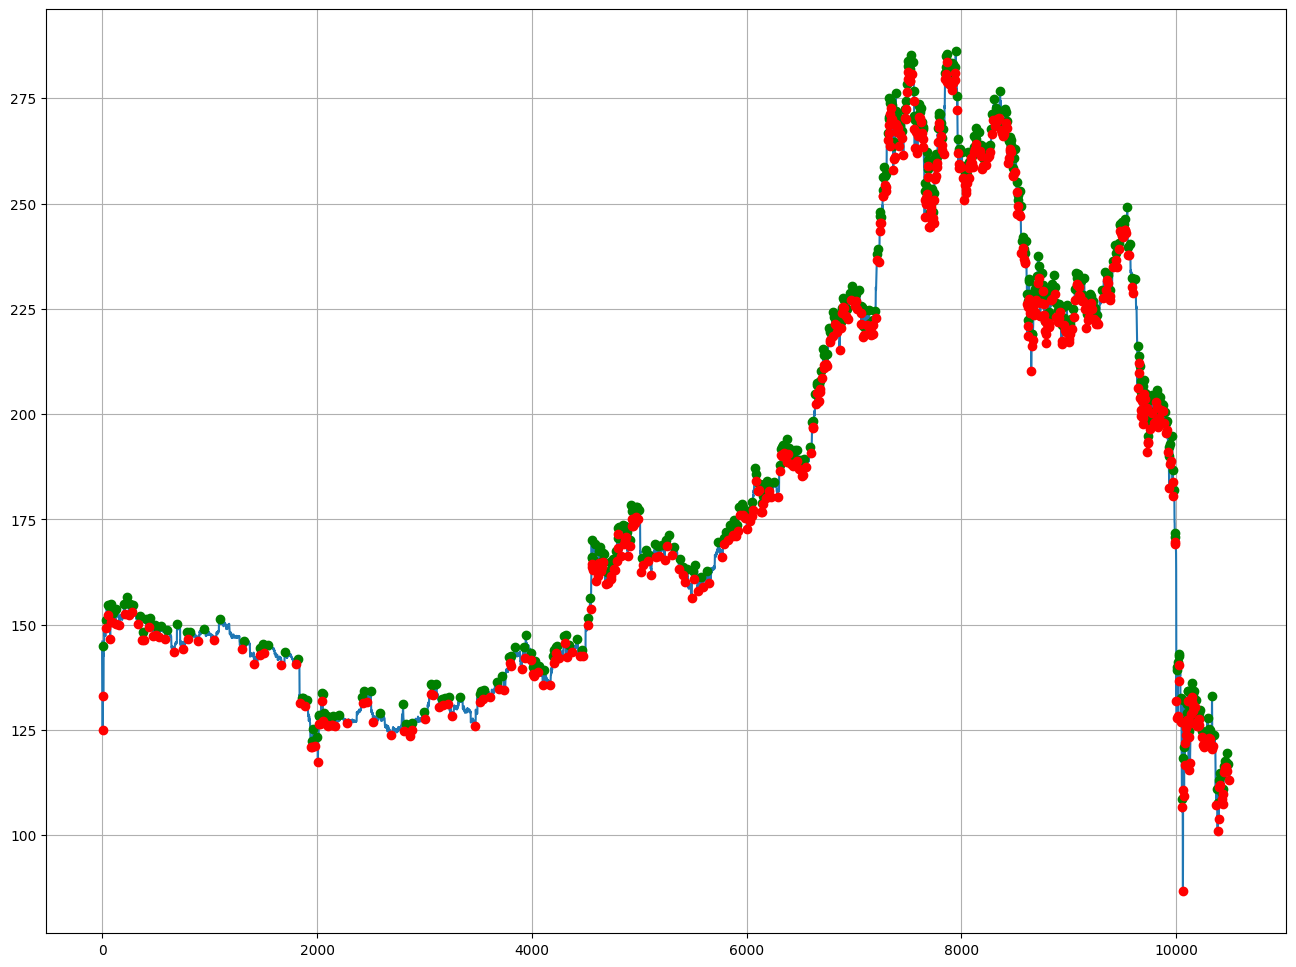

In [79]:
# plot peaks
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(df.close)

peak_x = peak_indexes
peak_y = df.close.values[peak_indexes]
ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
 
# plot valleys
valley_x = valley_indexes
valley_y = df.close.values[valley_indexes]
ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")

ax.grid()

In [80]:
peak_regions = []
for peak_index in peak_indexes:

    peak_regions.append(peak_index)

    for j in range(min(max(peak_index, len(df.close.values) - max(peak_indexes))-1, 5)):

        if peak_index+j >= len(df.close):
            break

        print(peak_index-j, peak_index+j)
        if np.abs(df.close.values[peak_index-j] - df.close.values[peak_index]) < mean_std/4:

            peak_regions.append(peak_index-j)
        elif np.abs(df.close.values[peak_index+j] - df.close.values[peak_index]) < mean_std/4:
            peak_regions.append(peak_index+j)        
print(len(peak_regions) - len(peak_indexes))
valley_regions = []
for valley_index in valley_indexes:
    # for j in range(min(valley_index, len(df.close.values) - max(valley_indexes), 5)):
    for j in range(min(max(valley_index, len(df.close.values) - max(peak_indexes))-1, 5)):
        if np.abs(df.close.values[valley_index-j] - df.close.values[valley_index]) < mean_std/4:
            valley_regions.append(valley_index-j)
        elif np.abs(df.close.values[valley_index+j] - df.close.values[valley_index]) < mean_std/4:
            valley_regions.append(valley_index+j)    
print(len(valley_regions) - len(valley_indexes))

3 3
2 4
1 5
0 6
-1 7
31 31
30 32
29 33
28 34
27 35
50 50
49 51
48 52
47 53
46 54
68 68
67 69
66 70
65 71
64 72
75 75
74 76
73 77
72 78
71 79
77 77
76 78
75 79
74 80
73 81
100 100
99 101
98 102
97 103
96 104
128 128
127 129
126 130
125 131
124 132
201 201
200 202
199 203
198 204
197 205
224 224
223 225
222 226
221 227
220 228
259 259
258 260
257 261
256 262
255 263
288 288
287 289
286 290
285 291
284 292
351 351
350 352
349 353
348 354
347 355
373 373
372 374
371 375
370 376
369 377
409 409
408 410
407 411
406 412
405 413
445 445
444 446
443 447
442 448
441 449
490 490
489 491
488 492
487 493
486 494
504 504
503 505
502 506
501 507
500 508
547 547
546 548
545 549
544 550
543 551
604 604
603 605
602 606
601 607
600 608
694 694
693 695
692 696
691 697
690 698
786 786
785 787
784 788
783 789
782 790
819 819
818 820
817 821
816 822
815 823
950 950
949 951
948 952
947 953
946 954
1099 1099
1098 1100
1097 1101
1096 1102
1095 1103
1322 1322
1321 1323
1320 1324
1319 1325
1318 1326
1465 1465
146

In [81]:
len(peak_regions) - len(peak_indexes)

749

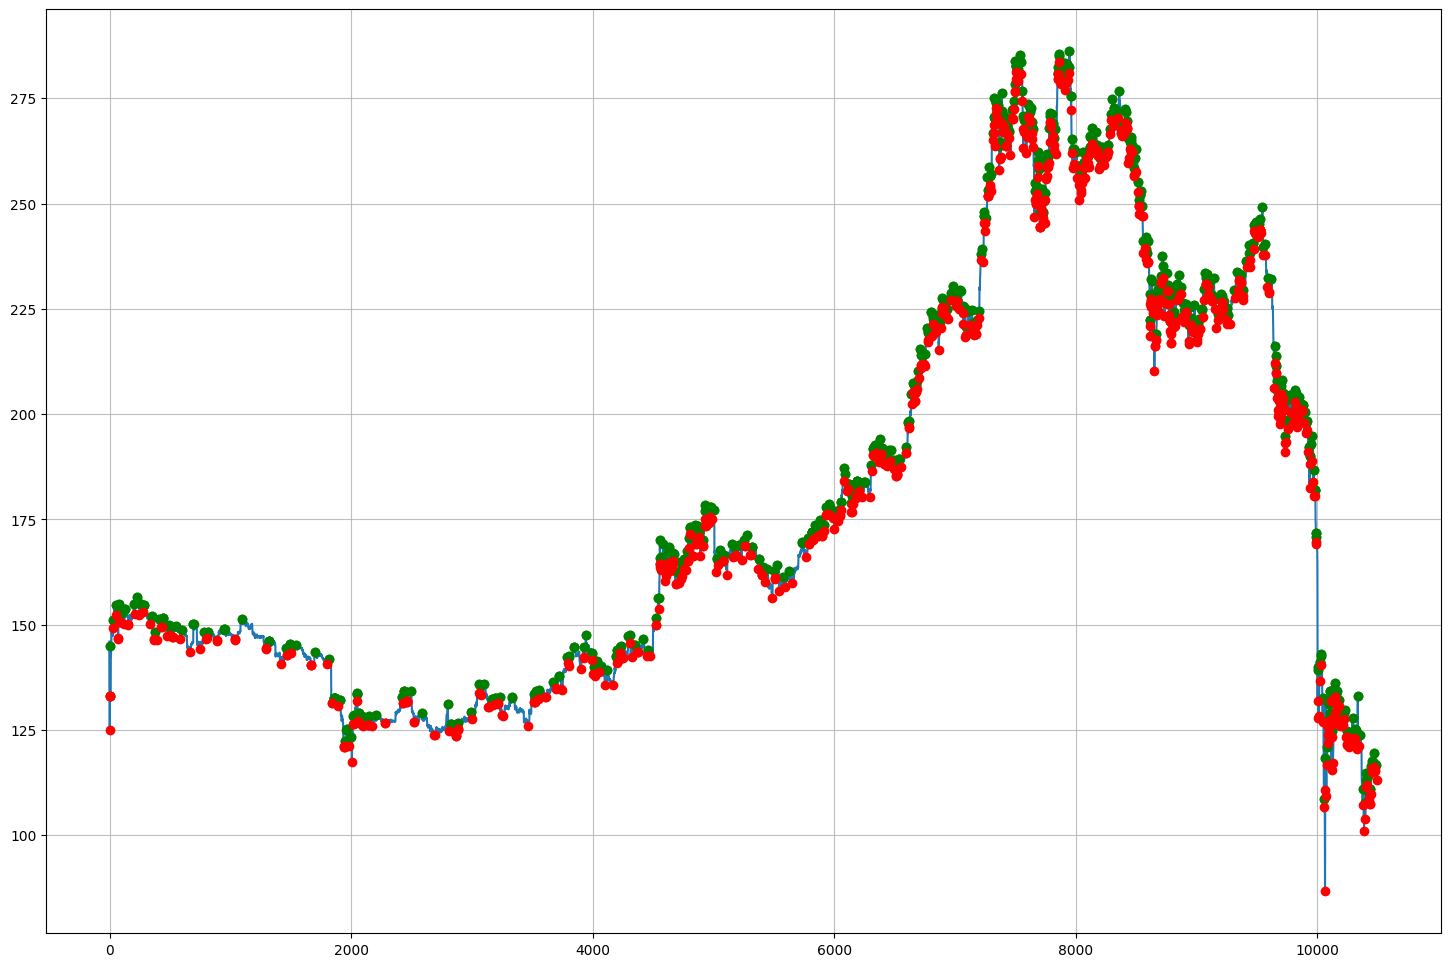

In [82]:
df = sdb.data
(fig, ax) = plt.subplots(figsize=(18,12))
ax.plot(df.close)

peak_x = peak_regions
peak_y = df.close.values[peak_regions]
ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")

valley_x = valley_regions
valley_y = df.close.values[valley_regions]
ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
ax.grid(which='both', alpha=0.8)
ax.grid(True, which="minor")


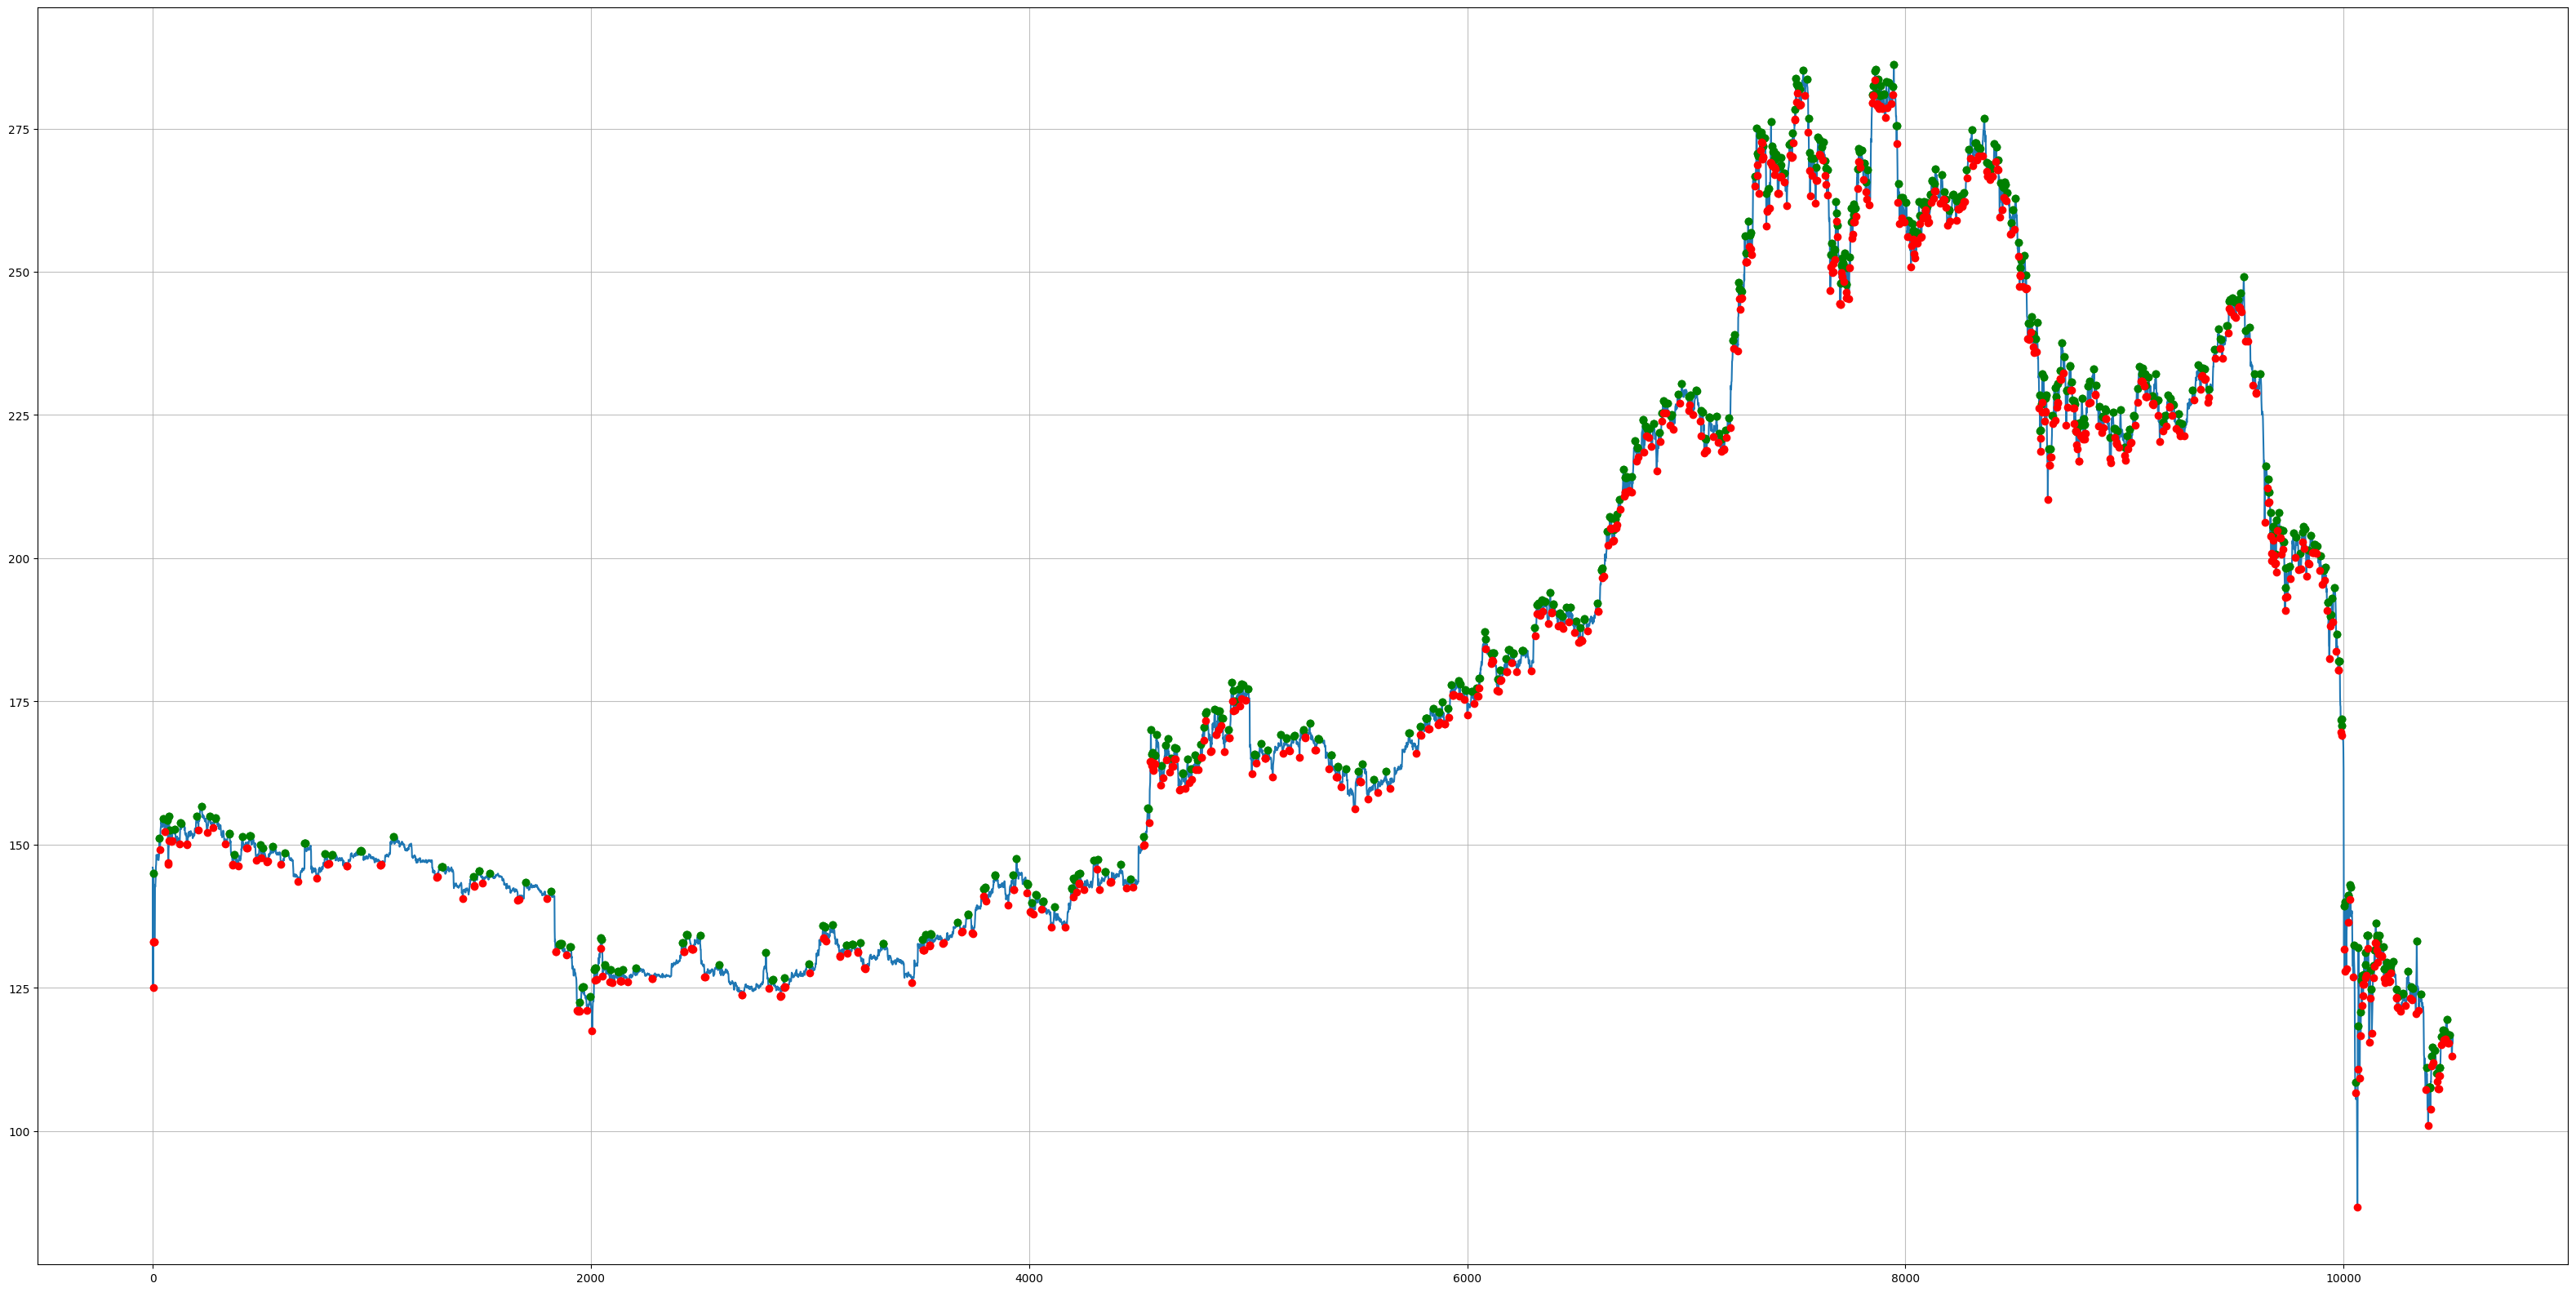

In [83]:
df = sdb.data
(fig, ax) = plt.subplots(figsize=(40,20))
ax.plot(df.close)
peak_x = peak_regions
peak_y = df.close.values[peak_regions]
ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")

valley_x = valley_regions
valley_y = df.close.values[valley_regions]
ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
ax.grid(which='both', alpha=0.8)
ax.grid(True, which="minor")

In [85]:
labels = [1 if i in peak_regions else (-1 if i in valley_regions else 0) for i in range(len(df.close.values))]
labels = pd.DataFrame(labels, columns=['labels'])
df = pd.concat([df, labels], axis=1)
print(labels[labels!=0].dropna())
    

       labels
2        -1.0
3         1.0
4        -1.0
5        -1.0
6        -1.0
...       ...
10478    -1.0
10480     1.0
10482     1.0
10483     1.0
10494    -1.0

[1453 rows x 1 columns]


In [86]:
df


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume,labels,labels
0,2019-11-27 07:45:00,146.00,146.00,146.00,146.00,0.010,2019-11-27 07:59:59.999,1.460000e+00,1,0.000,0.000000e+00,0,0
1,2019-11-27 08:00:00,146.00,146.00,146.00,146.00,0.000,2019-11-27 08:14:59.999,0.000000e+00,0,0.000,0.000000e+00,0,0
2,2019-11-27 08:15:00,125.03,125.03,125.03,125.03,0.010,2019-11-27 08:29:59.999,1.250300e+00,1,0.000,0.000000e+00,-1,-1
3,2019-11-27 08:30:00,145.00,145.00,145.00,145.00,0.020,2019-11-27 08:44:59.999,2.900000e+00,2,0.000,0.000000e+00,1,1
4,2019-11-27 08:45:00,145.01,145.01,133.00,133.00,0.050,2019-11-27 08:59:59.999,6.770100e+00,2,0.010,1.450100e+00,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,2020-03-17 14:00:00,113.09,114.91,112.51,113.82,35557.698,2020-03-17 14:14:59.999,4.046765e+06,7112,18061.825,2.055813e+06,0,0
10496,2020-03-17 14:15:00,113.79,115.50,113.55,115.29,25336.127,2020-03-17 14:29:59.999,2.901673e+06,5690,14325.847,1.641335e+06,0,0
10497,2020-03-17 14:30:00,115.28,115.68,114.04,115.40,34254.968,2020-03-17 14:44:59.999,3.937871e+06,5930,17229.602,1.981916e+06,0,0
10498,2020-03-17 14:45:00,115.40,115.68,114.77,115.39,19647.917,2020-03-17 14:59:59.999,2.263713e+06,3767,11837.663,1.364054e+06,0,0


In [87]:
if DUMP == 'json':
    df.to_json(os.path.join(DATA_DIR, tk1, f"{PAIR}_{TIMEFRAME}.json"))
elif DUMP == 'csv':
    df.to_csv(os.path.join(DATA_DIR, tk1, f"{PAIR}_{TIMEFRAME}_features.csv"))    
    labels.to_csv(os.path.join(DATA_DIR, tk1, f"{PAIR}_{TIMEFRAME}_labels.csv")) 

In [88]:
data_path = os.path.join(DATA_DIR, tk1, f"{PAIR}_{TIMEFRAME}")
print(data_path)       
labels = pd.read_csv(data_path + "_labels.csv")
labels.drop(['Unnamed: 0'], axis=1, inplace=True)
features = pd.read_csv(data_path + "_features.csv")
features.drop(['Unnamed: 0'], axis=1, inplace=True)
print(labels)
print(features)

data\ETHUSDT\2018-10-14_010000_15m_2022-10-05_010000\ETHUSDT_15m
       labels
0           0
1           0
2          -1
3           1
4          -1
...       ...
10495       0
10496       0
10497       0
10498       0
10499       0

[10500 rows x 1 columns]
                 open_time    open    high     low   close     volume  \
0      2019-11-27 07:45:00  146.00  146.00  146.00  146.00      0.010   
1      2019-11-27 08:00:00  146.00  146.00  146.00  146.00      0.000   
2      2019-11-27 08:15:00  125.03  125.03  125.03  125.03      0.010   
3      2019-11-27 08:30:00  145.00  145.00  145.00  145.00      0.020   
4      2019-11-27 08:45:00  145.01  145.01  133.00  133.00      0.050   
...                    ...     ...     ...     ...     ...        ...   
10495  2020-03-17 14:00:00  113.09  114.91  112.51  113.82  35557.698   
10496  2020-03-17 14:15:00  113.79  115.50  113.55  115.29  25336.127   
10497  2020-03-17 14:30:00  115.28  115.68  114.04  115.40  34254.968   
10498  2020

In [89]:
sdb.data = df
features =sdb.data

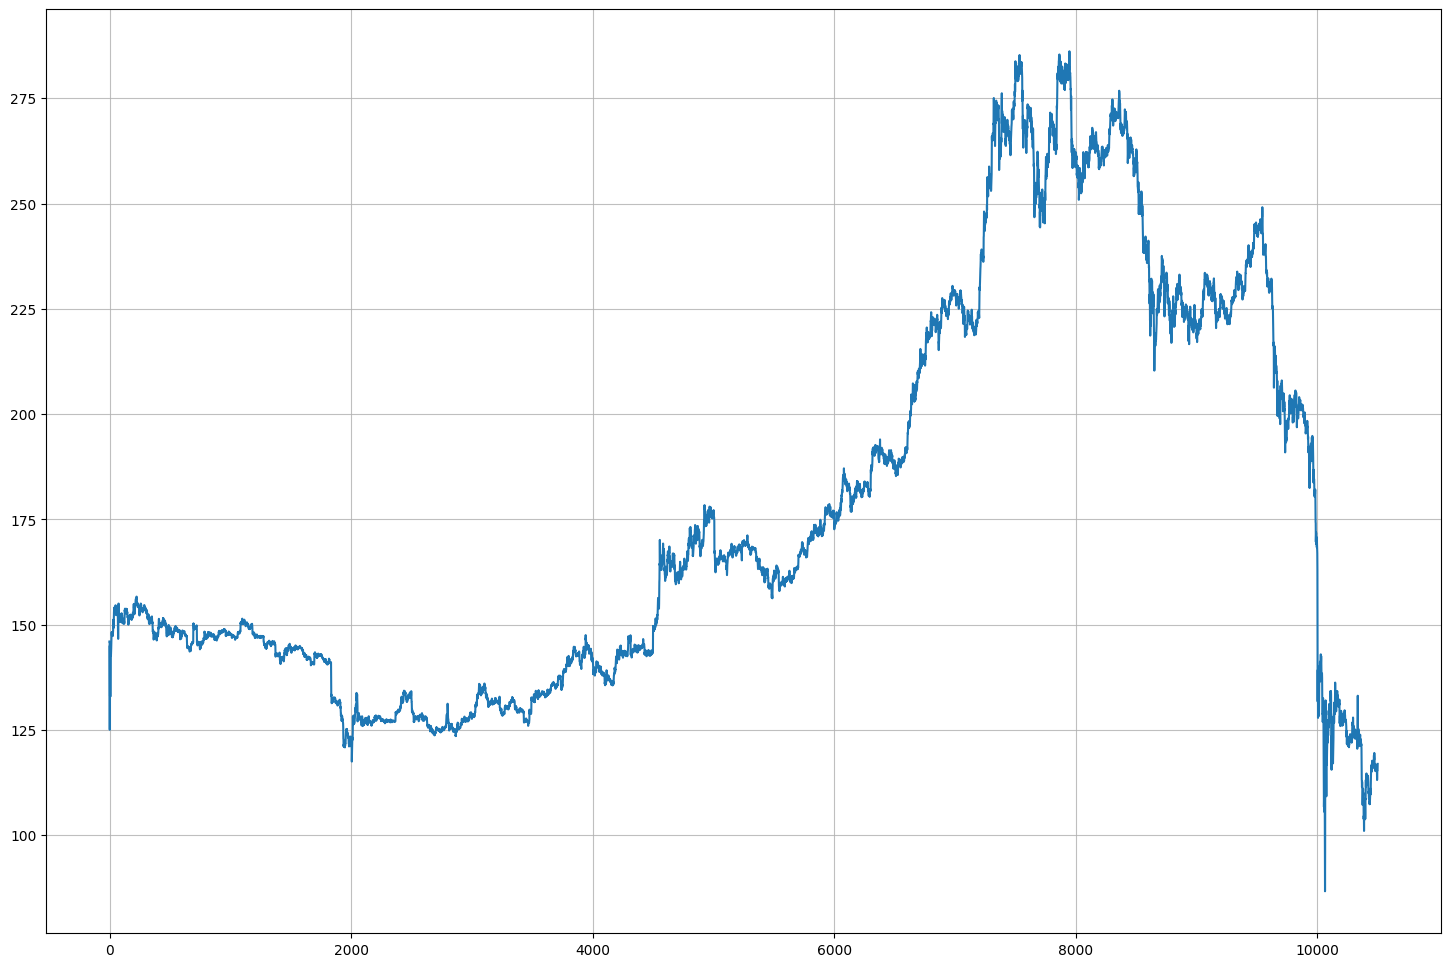

In [90]:
(fig, ax) = plt.subplots(figsize=(18,12))
ax.plot(features.close)
none = []
for i, l in enumerate(features.labels):
    if l == 1:
        peak_x = peak_regions
        peak_y = features.close.values[peak_regions]
        ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
    elif l == -1:
        valley_x = valley_regions
        valley_y = features.close.values[valley_regions]
        ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
    elif l == 0:
        none.append(i)
none_x = none
none_y = df.close.values[none]
# ax.plot(none_x, none_y, marker='o', linestyle="None", color='yellow', alpha=0.01, label="Valleys")        
# ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
# ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
ax.grid(which='both', alpha=0.8)
ax.grid(True, which="minor")

In [91]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, data_path, transform=None, target_transform=None):

        # any additional label treatment
        self.labels = pd.read_csv(data_path + "_labels.csv")
        self.labels.drop(['Unnamed: 0'], axis=1, inplace=True)
        
        #feature engineering
        self.features = pd.read_csv(data_path + "_features.csv")
        self.features.drop(['Unnamed: 0'], axis=1, inplace=True)
        self.features.drop(['close_time'], axis=1, inplace=True)
        self.features.drop(['labels'], axis=1, inplace=True)
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):

        feature = self.features.iloc[idx, :]
        label = self.labels.iloc[idx]

        if self.transform:
            feature = self.transform(feature)
        if self.target_transform:
            label = self.target_transform(label)
        return feature, label

In [92]:
ds = CustomDataset(data_path)


In [93]:
from torch.utils.data import DataLoader

dataloader = DataLoader(ds, batch_size=64, shuffle=True)


In [94]:
ds.features

,open_time,open,high,low,close,volume,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume,labels.1
0,2019-11-27 07:45:00,146.00,146.00,146.00,146.00,0.010,1.460000e+00,1,0.000,0.000000e+00,0
1,2019-11-27 08:00:00,146.00,146.00,146.00,146.00,0.000,0.000000e+00,0,0.000,0.000000e+00,0
2,2019-11-27 08:15:00,125.03,125.03,125.03,125.03,0.010,1.250300e+00,1,0.000,0.000000e+00,-1
3,2019-11-27 08:30:00,145.00,145.00,145.00,145.00,0.020,2.900000e+00,2,0.000,0.000000e+00,1
4,2019-11-27 08:45:00,145.01,145.01,133.00,133.00,0.050,6.770100e+00,2,0.010,1.450100e+00,-1
...,...,...,...,...,...,...,...,...,...,...,...
10495,2020-03-17 14:00:00,113.09,114.91,112.51,113.82,35557.698,4.046765e+06,7112,18061.825,2.055813e+06,0
10496,2020-03-17 14:15:00,113.79,115.50,113.55,115.29,25336.127,2.901673e+06,5690,14325.847,1.641335e+06,0
10497,2020-03-17 14:30:00,115.28,115.68,114.04,115.40,34254.968,3.937871e+06,5930,17229.602,1.981916e+06,0
10498,2020-03-17 14:45:00,115.40,115.68,114.77,115.39,19647.917,2.263713e+06,3767,11837.663,1.364054e+06,0


In [95]:
ds.labels

,labels
0,0
1,0
2,-1
3,1
4,-1
...,...
10495,0
10496,0
10497,0
10498,0


In [96]:
dataloader.dataset.features

,open_time,open,high,low,close,volume,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume,labels.1
0,2019-11-27 07:45:00,146.00,146.00,146.00,146.00,0.010,1.460000e+00,1,0.000,0.000000e+00,0
1,2019-11-27 08:00:00,146.00,146.00,146.00,146.00,0.000,0.000000e+00,0,0.000,0.000000e+00,0
2,2019-11-27 08:15:00,125.03,125.03,125.03,125.03,0.010,1.250300e+00,1,0.000,0.000000e+00,-1
3,2019-11-27 08:30:00,145.00,145.00,145.00,145.00,0.020,2.900000e+00,2,0.000,0.000000e+00,1
4,2019-11-27 08:45:00,145.01,145.01,133.00,133.00,0.050,6.770100e+00,2,0.010,1.450100e+00,-1
...,...,...,...,...,...,...,...,...,...,...,...
10495,2020-03-17 14:00:00,113.09,114.91,112.51,113.82,35557.698,4.046765e+06,7112,18061.825,2.055813e+06,0
10496,2020-03-17 14:15:00,113.79,115.50,113.55,115.29,25336.127,2.901673e+06,5690,14325.847,1.641335e+06,0
10497,2020-03-17 14:30:00,115.28,115.68,114.04,115.40,34254.968,3.937871e+06,5930,17229.602,1.981916e+06,0
10498,2020-03-17 14:45:00,115.40,115.68,114.77,115.39,19647.917,2.263713e+06,3767,11837.663,1.364054e+06,0
